# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.joe,
#    parameters=np.array([[2.5]]), rotation=90
#    )


copula_pv = pv.Bicop(
    family=pv.BicopFamily.clayton,
    parameters=np.array([[2.0]]), rotation=0
    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_3477200/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_3477200/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_3477200/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-16 14:15:28,014] A new study created in RDB with name: no-name-1912210c-e206-4ba0-9a04-0be45aef580f
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4403, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:01<14:44,  2.26it/s]

current_loss: tensor(1.4353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.458131194114685
current_loss: tensor(1.4353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4318050146102905


  0%|          | 3/2000 [00:01<11:23,  2.92it/s]

current_loss: tensor(1.4001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4336113929748535
current_loss: tensor(1.3995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:01,  3.32it/s]

current_loss: tensor(1.3994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4332472085952759
current_loss: tensor(1.3994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4002, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:41,  3.43it/s]


current_loss: tensor(1.3992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4327383041381836
current_loss: tensor(1.3992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4324309825897217
current_loss: tensor(1.3991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4319771528244019
Early Stop at iteration 6 with minimal loss tensor(1.4318, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<04:46,  6.99it/s]

current_loss: tensor(1.4012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3968945741653442
current_loss: tensor(1.3680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3225, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:30,  7.39it/s]

current_loss_val:  1.3346447944641113
current_loss: tensor(1.3225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:46,  4.91it/s]

current_loss_val:  1.303967833518982
current_loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:56,  4.80it/s]

current_loss_val:  1.292096495628357
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:57,  4.18it/s]

current_loss_val:  1.2902605533599854
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<10:09,  3.27it/s]

current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2888089418411255
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<12:01,  2.76it/s]

current_loss_val:  1.2845228910446167
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<12:55,  2.57it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2831611633300781
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<13:24,  2.47it/s]

current_loss_val:  1.2821906805038452
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:03<11:51,  2.80it/s]

current_loss_val:  1.2760038375854492
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:22,  3.53it/s]

current_loss_val:  1.2736655473709106
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272154688835144


  1%|          | 13/2000 [00:03<08:38,  3.83it/s]

current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716586589813232


  1%|          | 14/2000 [00:03<08:14,  4.02it/s]

current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270883321762085


  1%|          | 15/2000 [00:04<08:16,  4.00it/s]

current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706263065338135


  1%|          | 16/2000 [00:04<08:22,  3.95it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708033323287964


  1%|          | 17/2000 [00:04<08:24,  3.93it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271295189857483


  1%|          | 18/2000 [00:04<07:51,  4.20it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272254228591919


  1%|          | 19/2000 [00:05<07:23,  4.47it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732186317443848


  1%|          | 19/2000 [00:05<09:27,  3.49it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737139463424683
Early Stop at iteration 19 with minimal loss tensor(1.2706, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:15:42,291] Trial 0 finished with value: -2.541252374649048 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.793714302075365, 'penalty_decorrelation_ridge_second_difference': 23.084859640091466}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:15,  7.83it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709028720855713
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708876132965088


  0%|          | 4/2000 [00:00<03:41,  9.01it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720811367034912
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713009119033813


  0%|          | 6/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713204622268677
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714905738830566
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:00,  8.29it/s]


current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713701725006104
Early Stop at iteration 6 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:44,110] Trial 1 finished with value: -2.5417752265930176 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.812859936520178, 'penalty_decorrelation_ridge_second_difference': 15.9698959888158}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 2/2000 [00:00<03:06, 10.71it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716306447982788
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710226774215698
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:05, 10.74it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712186574935913
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271189570426941
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:23,  9.80it/s]

current_loss_val:  1.2726930379867554
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272244930267334
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:50,  8.66it/s]


current_loss_val:  1.2727469205856323
Early Stop at iteration 6 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:46,158] Trial 2 finished with value: -2.5420453548431396 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.093575419916913, 'penalty_decorrelation_ridge_second_difference': 8.080280592396035}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:15,  7.81it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708451747894287
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270914912223816


  0%|          | 4/2000 [00:00<03:41,  9.00it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715723514556885
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719156742095947


  0%|          | 5/2000 [00:00<04:10,  7.97it/s]


current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719929218292236
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723900079727173
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:48,283] Trial 3 finished with value: -2.5416903495788574 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.86907220395143, 'penalty_decorrelation_ridge_second_difference': 21.33524505995223}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:16,  7.78it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270810604095459
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709074020385742


  0%|          | 4/2000 [00:00<03:43,  8.94it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271667242050171
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721102237701416


  0%|          | 5/2000 [00:00<04:11,  7.95it/s]


current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723290920257568
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733584642410278
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:50,342] Trial 4 finished with value: -2.5416204929351807 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.371842046949812, 'penalty_decorrelation_ridge_second_difference': 27.69529210770581}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271043300628662
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270869493484497


  0%|          | 3/2000 [00:00<03:26,  9.69it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715283632278442
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714980840682983
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:15, 10.19it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718466520309448
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714821100234985
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:49,  8.70it/s]


current_loss_val:  1.2718589305877686
Early Stop at iteration 6 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:52,519] Trial 5 finished with value: -2.541738748550415 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.782706900518473, 'penalty_decorrelation_ridge_second_difference': 10.672584138312343}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:14,  7.85it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708628177642822
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270946741104126


  0%|          | 4/2000 [00:00<03:41,  9.02it/s]

current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717607021331787
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722351551055908


  0%|          | 5/2000 [00:00<04:10,  7.97it/s]


current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272365927696228
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730119228363037
Early Stop at iteration 5 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:54,688] Trial 6 finished with value: -2.5417256355285645 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.01481469356738, 'penalty_decorrelation_ridge_second_difference': 20.317526875778082}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:17,  7.77it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270792007446289
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708728313446045


  0%|          | 4/2000 [00:00<03:43,  8.93it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714234590530396
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717229127883911


  0%|          | 5/2000 [00:00<04:16,  7.79it/s]


current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718578577041626
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724045515060425
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:57,121] Trial 7 finished with value: -2.541584014892578 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.178769318735064, 'penalty_decorrelation_ridge_second_difference': 29.36735666205434}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:15,  7.82it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270829439163208
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709205150604248


  0%|          | 4/2000 [00:00<03:42,  8.96it/s]

current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716445922851562
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721221446990967


  0%|          | 5/2000 [00:00<04:11,  7.94it/s]


current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723026275634766
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273047685623169
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:15:59,213] Trial 8 finished with value: -2.541658878326416 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.29155619562282, 'penalty_decorrelation_ridge_second_difference': 24.184467528280923}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:31,  7.37it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709732055664062
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:28,  9.56it/s]

current_loss_val:  1.2710226774215698
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2727060317993164
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:14,  7.84it/s]

current_loss_val:  1.2721060514450073
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723664045333862
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732913494110107
Early Stop at iteration 5 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:01,350] Trial 9 finished with value: -2.5419461727142334 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.358894002383337, 'penalty_decorrelation_ridge_second_difference': 13.628533090525675}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:16,  7.78it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709051370620728
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708802223205566


  0%|          | 4/2000 [00:00<03:42,  8.98it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720412015914917
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712663412094116


  0%|          | 6/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712774276733398
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271417260169983
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:00,  8.28it/s]


current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712093591690063
Early Stop at iteration 6 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:03,570] Trial 10 finished with value: -2.541760206222534 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.6678475181541135, 'penalty_decorrelation_ridge_second_difference': 15.809911461771593}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:18,  7.74it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708736658096313
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<03:44,  8.91it/s]

current_loss_val:  1.270898461341858
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717682123184204
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:14,  7.85it/s]

current_loss_val:  1.2713431119918823
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27144455909729
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716548442840576
Early Stop at iteration 5 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:05,694] Trial 11 finished with value: -2.5417473316192627 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.235437787100889, 'penalty_decorrelation_ridge_second_difference': 18.03824988439958}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:15,  7.82it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708359956741333
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708615064620972


  0%|          | 4/2000 [00:00<03:42,  8.99it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713669538497925
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711975574493408


  0%|          | 5/2000 [00:00<04:10,  7.95it/s]


current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712390422821045
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712558507919312
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:07,690] Trial 12 finished with value: -2.5416719913482666 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9240364036223283, 'penalty_decorrelation_ridge_second_difference': 21.106429897108452}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:20,  7.69it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709622383117676
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:24,  9.77it/s]

current_loss_val:  1.270829200744629
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712278366088867
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271388053894043


  0%|          | 6/2000 [00:00<03:15, 10.21it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709307670593262
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271274447441101
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:54,  8.49it/s]


current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271189570426941
Early Stop at iteration 6 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:09,289] Trial 13 finished with value: -2.5416579246520996 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.433016005216009, 'penalty_decorrelation_ridge_second_difference': 13.28714751188422}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:21,  7.66it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708035707473755
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708697319030762


  0%|          | 3/2000 [00:00<03:26,  9.68it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713093757629395
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:16,  7.77it/s]

current_loss_val:  1.271577000617981
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716476917266846
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718113660812378
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:10,635] Trial 14 finished with value: -2.541606903076172 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.572234852820774, 'penalty_decorrelation_ridge_second_difference': 26.085637254717962}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:19,  7.69it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270794153213501
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270874261856079


  0%|          | 4/2000 [00:00<03:43,  8.92it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714155912399292
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717190980911255


  0%|          | 5/2000 [00:00<04:12,  7.89it/s]


current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718497514724731
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723561525344849
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:11,997] Trial 15 finished with value: -2.541588306427002 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.5205513728773, 'penalty_decorrelation_ridge_second_difference': 28.80113907808417}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:20,  7.69it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27078115940094
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27084481716156


  0%|          | 3/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711964845657349
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:14,  7.83it/s]

current_loss_val:  1.2713871002197266
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714484930038452
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715462446212769
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:13,358] Trial 16 finished with value: -2.541562080383301 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.748796354196864, 'penalty_decorrelation_ridge_second_difference': 29.818720704829637}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707864046096802
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708477973937988


  0%|          | 3/2000 [00:00<03:26,  9.66it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711949348449707
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:14,  7.84it/s]

current_loss_val:  1.2713936567306519
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714478969573975
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271506428718567
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:14,812] Trial 17 finished with value: -2.5415728092193604 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.253906524459746, 'penalty_decorrelation_ridge_second_difference': 28.62544441241496}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:15,  7.83it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707823514938354
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708414793014526


  0%|          | 4/2000 [00:00<03:43,  8.93it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711608409881592
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713406085968018


  0%|          | 5/2000 [00:00<04:11,  7.92it/s]


current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713879346847534
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271414875984192
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:16,418] Trial 18 finished with value: -2.541564702987671 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.0547240972383083, 'penalty_decorrelation_ridge_second_difference': 29.27629788980683}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 2/2000 [00:00<03:08, 10.60it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716783285140991
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711756229400635
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:07, 10.63it/s]

current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719494104385376
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723546028137207
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:38,  9.13it/s]

current_loss_val:  1.2765001058578491
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734287977218628
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736482620239258
Early Stop at iteration 6 with minimal loss tensor(1.2712, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:17,875] Trial 19 finished with value: -2.542351007461548 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.91966459622426, 'penalty_decorrelation_ridge_second_difference': 5.07333018582278}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:19,  7.70it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708123922348022
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708725929260254


  0%|          | 3/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713098526000977
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:13,  7.86it/s]

current_loss_val:  1.271558403968811
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716045379638672
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717061042785645
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:19,217] Trial 20 finished with value: -2.5416245460510254 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.087514146604628, 'penalty_decorrelation_ridge_second_difference': 24.488879118961}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707868814468384
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708396911621094


  0%|          | 3/2000 [00:00<03:26,  9.66it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711330652236938
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:13,  7.87it/s]

current_loss_val:  1.2713059186935425
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713345289230347
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712945938110352
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:20,582] Trial 21 finished with value: -2.5415737628936768 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.23866919695676536, 'penalty_decorrelation_ridge_second_difference': 28.17349771797086}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:20,  7.66it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707815170288086
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708446979522705


  0%|          | 4/2000 [00:00<03:44,  8.91it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711938619613647
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713831663131714


  0%|          | 5/2000 [00:00<04:12,  7.89it/s]


current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714428901672363
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715325355529785
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:21,980] Trial 22 finished with value: -2.5415632724761963 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.494245520470975, 'penalty_decorrelation_ridge_second_difference': 29.690485381130017}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:19,  7.69it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708022594451904
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:32,  4.42it/s]

current_loss_val:  1.2708739042282104
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713528871536255
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:33,  5.98it/s]

current_loss_val:  1.2716453075408936
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27173912525177
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720122337341309
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:23,636] Trial 23 finished with value: -2.541604518890381 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.212950579799855, 'penalty_decorrelation_ridge_second_difference': 26.649269679604515}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707852125167847
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:28,  9.57it/s]

current_loss_val:  1.2708500623703003
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712205648422241
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:16,  7.77it/s]

current_loss_val:  1.2714285850524902
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714940309524536
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716084718704224
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:25,018] Trial 24 finished with value: -2.5415706634521484 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.076877796405802, 'penalty_decorrelation_ridge_second_difference': 29.056975179462885}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:33,  7.31it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707831859588623
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.50it/s]

current_loss_val:  1.2708529233932495
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271268367767334
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:16,  7.77it/s]

current_loss_val:  1.2714875936508179
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271572232246399
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718032598495483
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:26,448] Trial 25 finished with value: -2.5415663719177246 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.177508103076075, 'penalty_decorrelation_ridge_second_difference': 29.949555290888018}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:16,  7.79it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709189653396606
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709431648254395


  0%|          | 3/2000 [00:00<03:27,  9.64it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722898721694946
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271599531173706


  0%|          | 5/2000 [00:00<04:13,  7.88it/s]


current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717304229736328
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722419500350952
Early Stop at iteration 5 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:27,840] Trial 26 finished with value: -2.5418379306793213 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.273024620917951, 'penalty_decorrelation_ridge_second_difference': 15.557303764419864}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:32,  7.33it/s]

current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270825743675232
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:29,  9.54it/s]

current_loss_val:  1.270877718925476
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713515758514404
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:16,  7.79it/s]

current_loss_val:  1.271537184715271
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715609073638916
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716729640960693
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:29,365] Trial 27 finished with value: -2.5416512489318848 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.237809279035636, 'penalty_decorrelation_ridge_second_difference': 22.611139353449566}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:19,  7.71it/s]

current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709252834320068
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271018147468567


  0%|          | 3/2000 [00:00<03:26,  9.69it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722004652023315
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272675633430481


  0%|          | 5/2000 [00:00<04:12,  7.89it/s]


current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272865653038025
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738420963287354
Early Stop at iteration 5 with minimal loss tensor(1.2709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-16 14:16:30,749] Trial 28 finished with value: -2.5418500900268555 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.168769308759032, 'penalty_decorrelation_ridge_second_difference': 16.356101162297467}. Best is trial 0 with value: -2.541252374649048.
  0%|          | 1/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270836591720581
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709100246429443


  0%|          | 3/2000 [00:00<03:27,  9.65it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715381383895874
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:14,  7.85it/s]

current_loss_val:  1.271912932395935
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720052003860474
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724019289016724
Early Stop at iteration 5 with minimal loss tensor(1.2708, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-16 14:16:32,190] Trial 29 finished with value: -2.541672945022583 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.299441277534065, 'penalty_decorrelation_ridge_second_difference': 22.339876788237717}. Best is trial 0 with value: -2.541252374649048.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4353, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:43, 22.94it/s]

current_loss: tensor(1.4353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3992, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:38, 25.43it/s]

current_loss: tensor(1.3991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3989, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:37, 26.28it/s]

current_loss: tensor(1.3988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3977, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:39, 24.81it/s]

current_loss: tensor(1.3977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:39, 25.10it/s]

current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:35, 27.17it/s]

current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:35, 27.66it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:35, 27.07it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:36, 26.59it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:35, 27.43it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:43, 21.80it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:42, 22.73it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:46, 20.65it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:44, 21.25it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:02<00:40, 23.35it/s]

current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:39, 23.46it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:02<00:37, 24.77it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:03<00:41, 22.53it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:03<00:41, 22.18it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:03<00:38, 23.63it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:03<00:39, 23.32it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:03<00:37, 23.97it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:04<00:33, 26.55it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:04<00:34, 26.26it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:04<00:32, 27.77it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 117/1000 [00:04<00:32, 26.81it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:05<00:32, 27.03it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 129/1000 [00:05<00:33, 26.34it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:05<00:32, 27.03it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 141/1000 [00:05<00:32, 26.38it/s]

current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 147/1000 [00:05<00:34, 24.73it/s]

current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 153/1000 [00:06<00:32, 25.80it/s]

current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 156/1000 [00:06<00:37, 22.42it/s]

current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 162/1000 [00:06<00:34, 24.57it/s]

current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 168/1000 [00:06<00:31, 26.16it/s]

current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 174/1000 [00:07<00:31, 26.61it/s]

current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 180/1000 [00:07<00:29, 27.97it/s]

current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 183/1000 [00:07<00:31, 26.19it/s]

current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 189/1000 [00:07<00:31, 25.90it/s]

current_loss: tensor(1.3970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 195/1000 [00:07<00:29, 27.43it/s]

current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 201/1000 [00:08<00:29, 27.13it/s]

current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 207/1000 [00:08<00:30, 26.37it/s]

current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 213/1000 [00:08<00:28, 27.80it/s]

current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 22%|██▏       | 216/1000 [00:08<00:43, 17.92it/s]

current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 22%|██▏       | 219/1000 [00:09<00:33, 23.56it/s]

current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 219 with minimal loss tensor(1.3967, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<01:40,  9.98it/s]

current_loss: tensor(1.3977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3903839588165283
current_loss: tensor(1.3618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3139758110046387
current_loss: tensor(1.3126, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:46,  9.34it/s]

current_loss: tensor(1.3194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.297379493713379
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.29298734664917
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:39,  9.96it/s]

current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2879247665405273
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2855199575424194
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:36, 10.27it/s]

current_loss_val:  1.2842317819595337
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2821484804153442


  1%|          | 9/1000 [00:01<02:23,  6.90it/s]

current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2776525020599365


  1%|          | 10/1000 [00:01<02:49,  5.85it/s]

current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731268405914307


  1%|          | 11/1000 [00:01<03:14,  5.09it/s]

current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705273628234863
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:02<03:44,  4.40it/s]

current_loss_val:  1.268452763557434
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:02<04:46,  3.44it/s]

current_loss_val:  1.2673120498657227
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:03<06:22,  2.58it/s]

current_loss_val:  1.2673486471176147
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:03<07:32,  2.18it/s]

current_loss_val:  1.2673585414886475
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:04<08:22,  1.96it/s]

current_loss_val:  1.2673903703689575
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:05<08:59,  1.82it/s]

current_loss_val:  1.2678776979446411
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:05<05:24,  3.03it/s]

current_loss_val:  1.2686794996261597
Early Stop at iteration 17 with minimal loss tensor(1.2673, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, 
                sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =2.0,
                tau_vi_sigma_init = 0.15,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 0/800 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 1/800 [00:07<1:34:47,  7.12s/it]


Iteration [1/800] train=7.1698    val_ELPD=-0.0411  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.50
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.15521  τ₁≈4.383  τ₂≈8.6562  |  (EB targets) τ₄*≈0.53533  τ₁*≈118.64  τ₂*≈163.31
E_qf_total≈37.3537  E_qf1≈0.3097  E_qf2≈0.3033
[monitor] τ₄·E_qf≈5.80  target≈20.00 | τ₁·E_qf1≈1.36  target≈36.74 | τ₂·E_qf2≈2.63  target≈49.54
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 2/800 [00:11<1:14:10,  5.58s/it]


Iteration [2/800] train=7.2041    val_ELPD=-0.0400  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.53
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.12372  τ₁≈3.8535  τ₂≈7.2052  |  (EB targets) τ₄*≈0.53712  τ₁*≈117.93  τ₂*≈164.26
E_qf_total≈37.2290  E_qf1≈0.3140  E_qf2≈0.3004
[monitor] τ₄·E_qf≈4.61  target≈20.00 | τ₁·E_qf1≈1.21  target≈37.03 | τ₂·E_qf2≈2.16  target≈49.35
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 3/800 [00:16<1:07:28,  5.08s/it]


Iteration [3/800] train=7.2141    val_ELPD=-0.0391  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.55
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10048  τ₁≈3.6151  τ₂≈6.3788  |  (EB targets) τ₄*≈0.53942  τ₁*≈116.2  τ₂*≈163.83
E_qf_total≈37.0703  E_qf1≈0.3246  E_qf2≈0.3017
[monitor] τ₄·E_qf≈3.72  target≈20.00 | τ₁·E_qf1≈1.17  target≈37.72 | τ₂·E_qf2≈1.92  target≈49.43
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 4/800 [00:20<1:04:16,  4.85s/it]


Iteration [4/800] train=7.3568    val_ELPD=-0.0387  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.57
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.083014  τ₁≈3.5494  τ₂≈5.8988  |  (EB targets) τ₄*≈0.54142  τ₁*≈115  τ₂*≈163.64
E_qf_total≈36.9333  E_qf1≈0.3322  E_qf2≈0.3023
[monitor] τ₄·E_qf≈3.07  target≈20.00 | τ₁·E_qf1≈1.18  target≈38.20 | τ₂·E_qf2≈1.78  target≈49.47
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 5/800 [00:25<1:02:26,  4.71s/it]


Iteration [5/800] train=7.4866    val_ELPD=-0.0383  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.60
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.069599  τ₁≈3.5129  τ₂≈5.7034  |  (EB targets) τ₄*≈0.54273  τ₁*≈115.75  τ₂*≈166
E_qf_total≈36.8445  E_qf1≈0.3274  E_qf2≈0.2952
[monitor] τ₄·E_qf≈2.56  target≈20.00 | τ₁·E_qf1≈1.15  target≈37.90 | τ₂·E_qf2≈1.68  target≈49.00
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 6/800 [00:29<1:01:18,  4.63s/it]


Iteration [6/800] train=7.6099    val_ELPD=-0.0382  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.62
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.059081  τ₁≈3.4774  τ₂≈5.4714  |  (EB targets) τ₄*≈0.54417  τ₁*≈113.45  τ₂*≈160.86
E_qf_total≈36.7467  E_qf1≈0.3422  E_qf2≈0.3110
[monitor] τ₄·E_qf≈2.17  target≈20.00 | τ₁·E_qf1≈1.19  target≈38.82 | τ₂·E_qf2≈1.70  target≈50.03
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 7/800 [00:34<1:00:33,  4.58s/it]


Iteration [7/800] train=7.7625    val_ELPD=-0.0381  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.65
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.050628  τ₁≈3.427  τ₂≈5.3987  |  (EB targets) τ₄*≈0.54512  τ₁*≈113.74  τ₂*≈162.22
E_qf_total≈36.6825  E_qf1≈0.3403  E_qf2≈0.3067
[monitor] τ₄·E_qf≈1.86  target≈20.00 | τ₁·E_qf1≈1.17  target≈38.70 | τ₂·E_qf2≈1.66  target≈49.76
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 8/800 [00:38<1:00:00,  4.55s/it]


Iteration [8/800] train=7.8926    val_ELPD=-0.0378  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.68
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.043644  τ₁≈3.4231  τ₂≈5.413  |  (EB targets) τ₄*≈0.54628  τ₁*≈114.01  τ₂*≈163.34
E_qf_total≈36.6048  E_qf1≈0.3385  E_qf2≈0.3033
[monitor] τ₄·E_qf≈1.60  target≈20.00 | τ₁·E_qf1≈1.16  target≈38.59 | τ₂·E_qf2≈1.64  target≈49.53
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 9/800 [00:42<59:36,  4.52s/it]  


Iteration [9/800] train=8.0181    val_ELPD=-0.0376  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.70
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.037861  τ₁≈3.4182  τ₂≈5.3712  |  (EB targets) τ₄*≈0.54699  τ₁*≈114.25  τ₂*≈164.5
E_qf_total≈36.5576  E_qf1≈0.3369  E_qf2≈0.2997
[monitor] τ₄·E_qf≈1.38  target≈20.00 | τ₁·E_qf1≈1.15  target≈38.50 | τ₂·E_qf2≈1.61  target≈49.30
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 10/800 [00:48<1:04:25,  4.89s/it]


Iteration [10/800] train=8.1494    val_ELPD=-0.0375  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.73
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.033036  τ₁≈3.4085  τ₂≈5.2971  |  (EB targets) τ₄*≈0.54779  τ₁*≈113.6  τ₂*≈162.2
E_qf_total≈36.5039  E_qf1≈0.3412  E_qf2≈0.3068
[monitor] τ₄·E_qf≈1.21  target≈20.00 | τ₁·E_qf1≈1.16  target≈38.76 | τ₂·E_qf2≈1.63  target≈49.76
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 11/800 [00:53<1:02:37,  4.76s/it]


Iteration [11/800] train=8.2793    val_ELPD=-0.0374  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.75
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.02898  τ₁≈3.3978  τ₂≈5.3354  |  (EB targets) τ₄*≈0.54807  τ₁*≈113.57  τ₂*≈162.88
E_qf_total≈36.4851  E_qf1≈0.3414  E_qf2≈0.3047
[monitor] τ₄·E_qf≈1.06  target≈20.00 | τ₁·E_qf1≈1.16  target≈38.77 | τ₂·E_qf2≈1.63  target≈49.62
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 12/800 [00:57<1:01:21,  4.67s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 13/800 [01:02<1:00:28,  4.61s/it]


Iteration [13/800] train=8.6383    val_ELPD=-0.0373  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.80
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.022547  τ₁≈3.3079  τ₂≈5.3541  |  (EB targets) τ₄*≈0.54911  τ₁*≈112.99  τ₂*≈161.5
E_qf_total≈36.4162  E_qf1≈0.3452  E_qf2≈0.3090
[monitor] τ₄·E_qf≈0.82  target≈20.00 | τ₁·E_qf1≈1.14  target≈39.01 | τ₂·E_qf2≈1.65  target≈49.90
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 14/800 [01:06<59:48,  4.57s/it]  


Iteration [14/800] train=8.7775    val_ELPD=-0.0373  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.82
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.019985  τ₁≈3.4004  τ₂≈5.3047  |  (EB targets) τ₄*≈0.54974  τ₁*≈113.29  τ₂*≈162.2
E_qf_total≈36.3745  E_qf1≈0.3432  E_qf2≈0.3068
[monitor] τ₄·E_qf≈0.73  target≈20.00 | τ₁·E_qf1≈1.17  target≈38.88 | τ₂·E_qf2≈1.63  target≈49.76
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 15/800 [01:11<59:20,  4.54s/it]

NOT IMPROVED! Nr. 1

Iteration [15/800] train=8.8999    val_ELPD=-0.0373  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.85
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.017745  τ₁≈3.3829  τ₂≈5.2777  |  (EB targets) τ₄*≈0.55004  τ₁*≈112.89  τ₂*≈161.98
E_qf_total≈36.3548  E_qf1≈0.3459  E_qf2≈0.3075
[monitor] τ₄·E_qf≈0.65  target≈20.00 | τ₁·E_qf1≈1.17  target≈39.04 | τ₂·E_qf2≈1.62  target≈49.80
 ELPD trend → NOT improved! (1/10)


  2%|▏         | 16/800 [01:15<58:58,  4.51s/it]

NOT IMPROVED! Nr. 2


  2%|▏         | 17/800 [01:19<58:42,  4.50s/it]


Iteration [17/800] train=9.2591    val_ELPD=-0.0371  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.90
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.014122  τ₁≈3.3371  τ₂≈5.2878  |  (EB targets) τ₄*≈0.5501  τ₁*≈113.46  τ₂*≈163.62
E_qf_total≈36.3506  E_qf1≈0.3421  E_qf2≈0.3024
[monitor] τ₄·E_qf≈0.51  target≈20.00 | τ₁·E_qf1≈1.14  target≈38.81 | τ₂·E_qf2≈1.60  target≈49.48
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 18/800 [01:24<58:28,  4.49s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 19/800 [01:28<58:44,  4.51s/it]


Iteration [19/800] train=9.4793    val_ELPD=-0.0371  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.95
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.01131  τ₁≈3.2806  τ₂≈5.4216  |  (EB targets) τ₄*≈0.54978  τ₁*≈112.76  τ₂*≈162.72
E_qf_total≈36.3718  E_qf1≈0.3467  E_qf2≈0.3052
[monitor] τ₄·E_qf≈0.41  target≈20.00 | τ₁·E_qf1≈1.14  target≈39.10 | τ₂·E_qf2≈1.65  target≈49.66
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▎         | 20/800 [01:33<58:29,  4.50s/it]

NOT IMPROVED! Nr. 1

Iteration [20/800] train=9.6492    val_ELPD=-0.0372  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.97
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.010142  τ₁≈3.2861  τ₂≈5.293  |  (EB targets) τ₄*≈0.54939  τ₁*≈112.22  τ₂*≈162.01
E_qf_total≈36.3974  E_qf1≈0.3503  E_qf2≈0.3074
[monitor] τ₄·E_qf≈0.37  target≈20.00 | τ₁·E_qf1≈1.15  target≈39.31 | τ₂·E_qf2≈1.63  target≈49.80
 ELPD trend → NOT improved! (1/10)


  3%|▎         | 21/800 [01:37<58:17,  4.49s/it]


Iteration [21/800] train=9.7931    val_ELPD=-0.0370  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0090944  τ₁≈3.2647  τ₂≈5.3207  |  (EB targets) τ₄*≈0.54922  τ₁*≈113.24  τ₂*≈163.96
E_qf_total≈36.4086  E_qf1≈0.3436  E_qf2≈0.3014
[monitor] τ₄·E_qf≈0.33  target≈20.00 | τ₁·E_qf1≈1.12  target≈38.90 | τ₂·E_qf2≈1.60  target≈49.41
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 22/800 [01:42<1:00:29,  4.66s/it]

NOT IMPROVED! Nr. 1


  3%|▎         | 23/800 [01:47<59:39,  4.61s/it]  

NOT IMPROVED! Nr. 2


  3%|▎         | 24/800 [01:51<59:03,  4.57s/it]

NOT IMPROVED! Nr. 3


  3%|▎         | 25/800 [01:56<59:05,  4.57s/it]

NOT IMPROVED! Nr. 4

Iteration [25/800] train=9.6594    val_ELPD=-0.0370  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0059109  τ₁≈3.2491  τ₂≈5.4545  |  (EB targets) τ₄*≈0.5466  τ₁*≈111.92  τ₂*≈161.29
E_qf_total≈36.5835  E_qf1≈0.3523  E_qf2≈0.3097
[monitor] τ₄·E_qf≈0.22  target≈20.00 | τ₁·E_qf1≈1.14  target≈39.43 | τ₂·E_qf2≈1.69  target≈49.94
 ELPD trend → NOT improved! (4/10)


  3%|▎         | 26/800 [02:02<1:03:08,  4.89s/it]

NOT IMPROVED! Nr. 5


  3%|▎         | 27/800 [02:06<1:01:27,  4.77s/it]

NOT IMPROVED! Nr. 6


  4%|▎         | 28/800 [02:11<1:00:16,  4.68s/it]

NOT IMPROVED! Nr. 7


  4%|▎         | 29/800 [02:15<59:25,  4.62s/it]  


Iteration [29/800] train=9.5533    val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0040574  τ₁≈3.4238  τ₂≈5.222  |  (EB targets) τ₄*≈0.5425  τ₁*≈112.01  τ₂*≈161.25
E_qf_total≈36.8601  E_qf1≈0.3517  E_qf2≈0.3098
[monitor] τ₄·E_qf≈0.15  target≈20.00 | τ₁·E_qf1≈1.20  target≈39.39 | τ₂·E_qf2≈1.62  target≈49.95
 ELPD trend → IMPROVED! Congrats (0/10)


  4%|▍         | 30/800 [02:20<58:45,  4.58s/it]

NOT IMPROVED! Nr. 1

Iteration [30/800] train=9.5961    val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0038414  τ₁≈3.3601  τ₂≈5.2166  |  (EB targets) τ₄*≈0.54174  τ₁*≈112.43  τ₂*≈162.59
E_qf_total≈36.9115  E_qf1≈0.3489  E_qf2≈0.3056
[monitor] τ₄·E_qf≈0.14  target≈20.00 | τ₁·E_qf1≈1.17  target≈39.23 | τ₂·E_qf2≈1.59  target≈49.68
 ELPD trend → NOT improved! (1/10)


  4%|▍         | 31/800 [02:24<58:21,  4.55s/it]

NOT IMPROVED! Nr. 2


  4%|▍         | 32/800 [02:29<58:01,  4.53s/it]

NOT IMPROVED! Nr. 3


  4%|▍         | 33/800 [02:33<57:46,  4.52s/it]

NOT IMPROVED! Nr. 4


  4%|▍         | 34/800 [02:38<57:35,  4.51s/it]

NOT IMPROVED! Nr. 5


  4%|▍         | 35/800 [02:42<57:25,  4.50s/it]

NOT IMPROVED! Nr. 6

Iteration [35/800] train=8.9457    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0575 σmin=0.0573 σmax=0.0575  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0029016  τ₁≈3.2446  τ₂≈4.9406  |  (EB targets) τ₄*≈0.53916  τ₁*≈99.683  τ₂*≈137.46
E_qf_total≈37.0884  E_qf1≈0.4447  E_qf2≈0.3980
[monitor] τ₄·E_qf≈0.11  target≈20.00 | τ₁·E_qf1≈1.44  target≈44.33 | τ₂·E_qf2≈1.97  target≈54.71
 ELPD trend → NOT improved! (6/10)


  4%|▍         | 36/800 [02:47<57:17,  4.50s/it]

NOT IMPROVED! Nr. 7


  5%|▍         | 37/800 [02:51<57:12,  4.50s/it]

NOT IMPROVED! Nr. 8


  5%|▍         | 38/800 [02:56<57:06,  4.50s/it]

NOT IMPROVED! Nr. 9


  5%|▍         | 38/800 [03:00<1:00:19,  4.75s/it]

NOT IMPROVED! Nr. 10
Early stop @ epoch 39: no val improvement for 10 epochs.


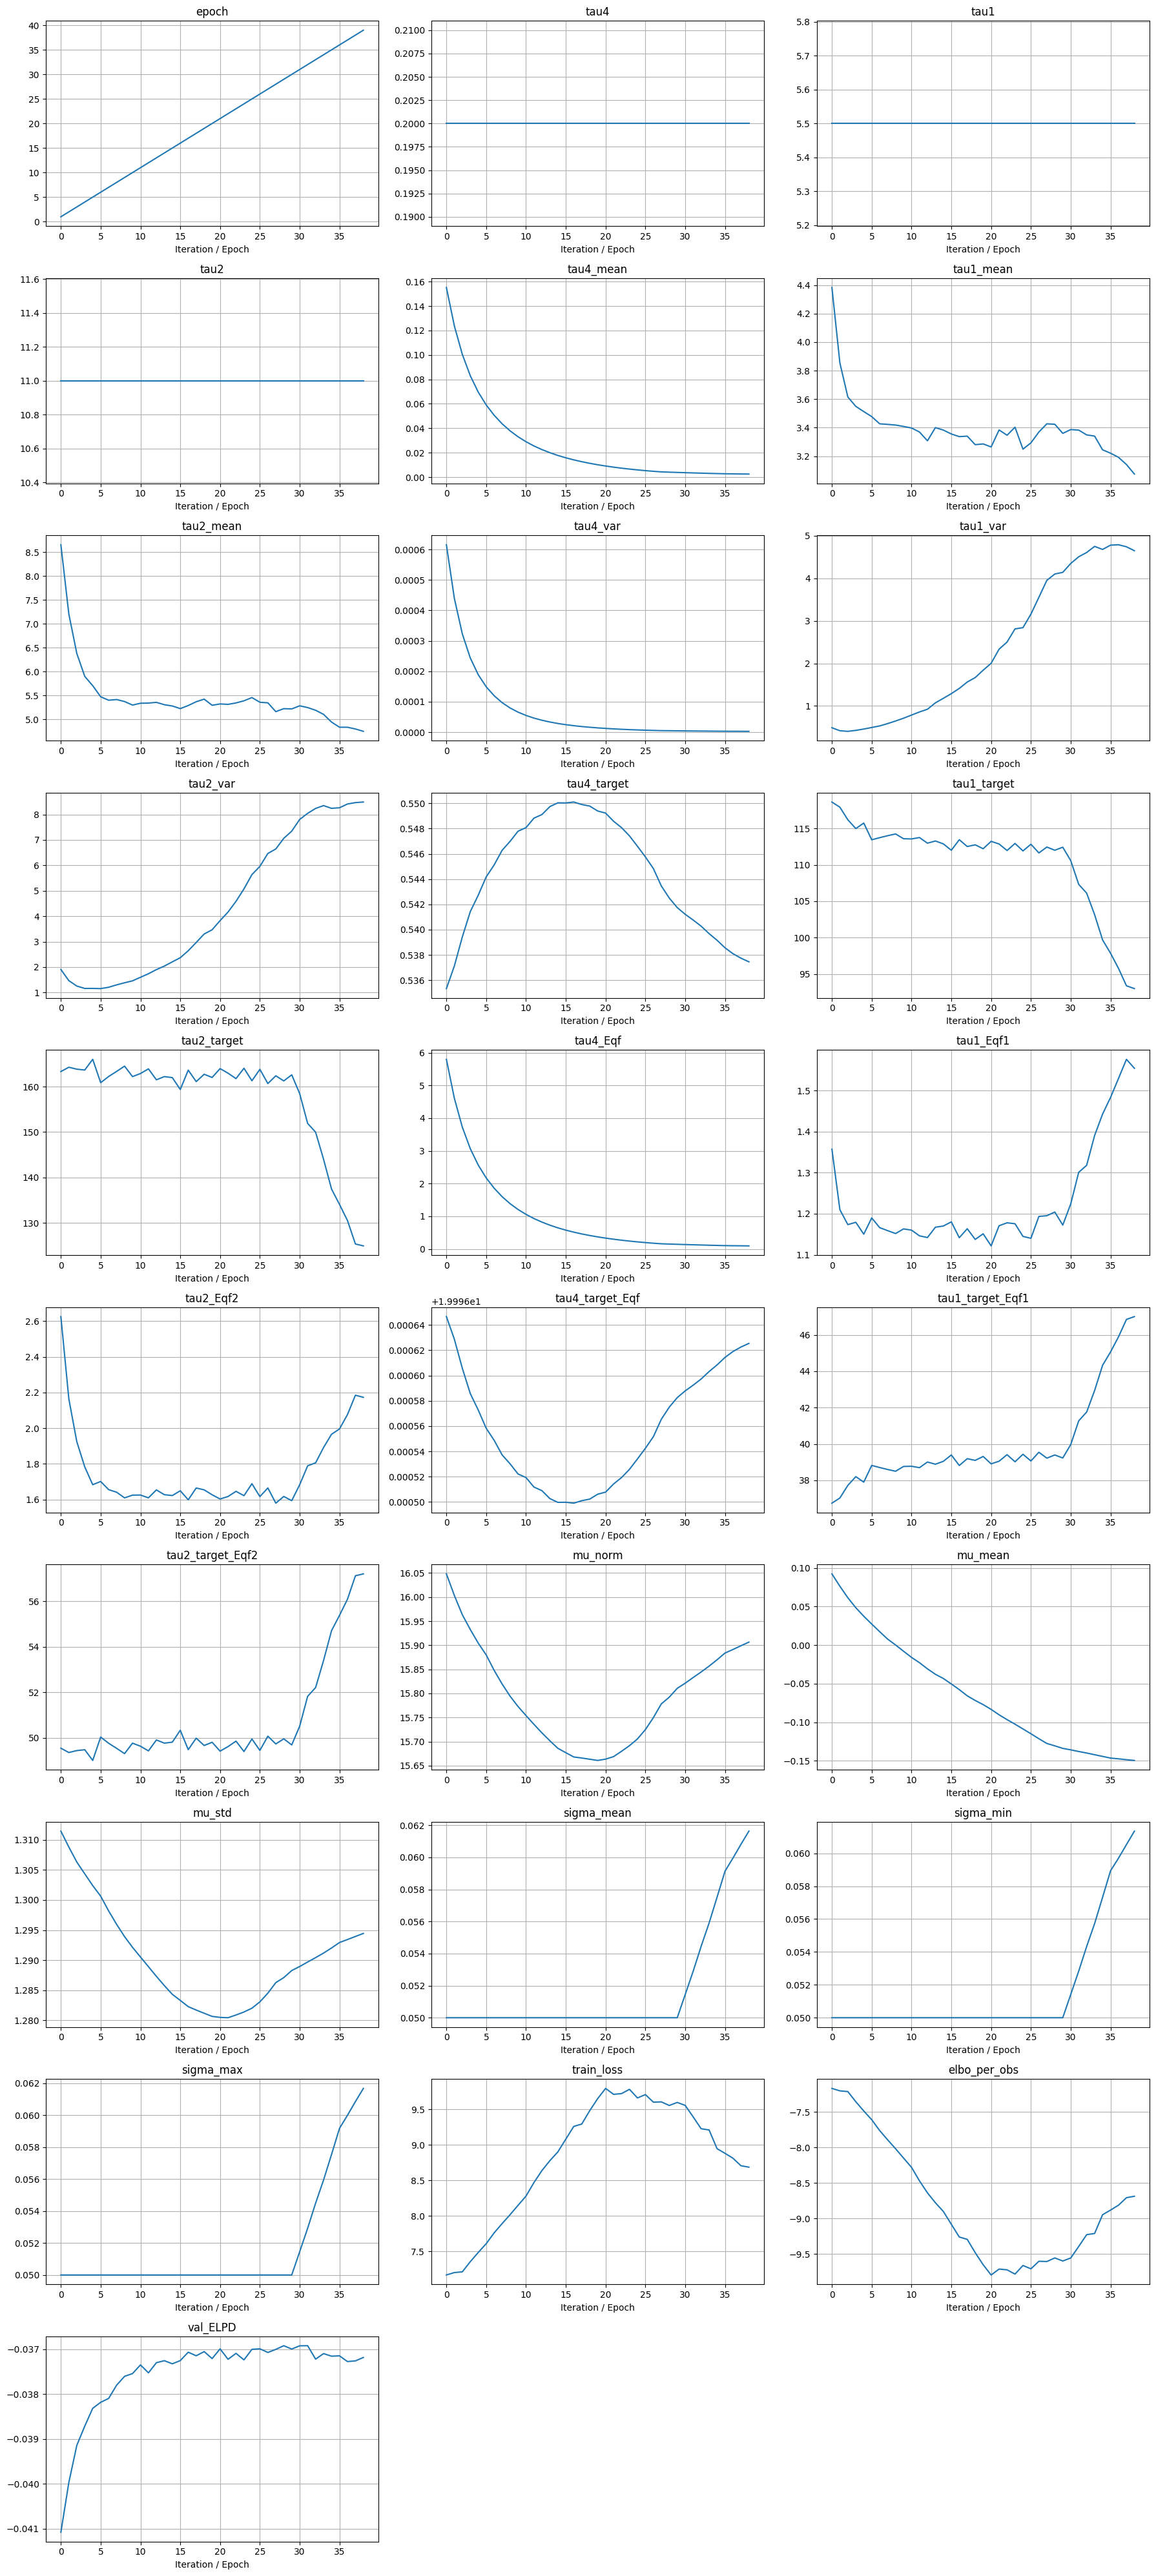

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

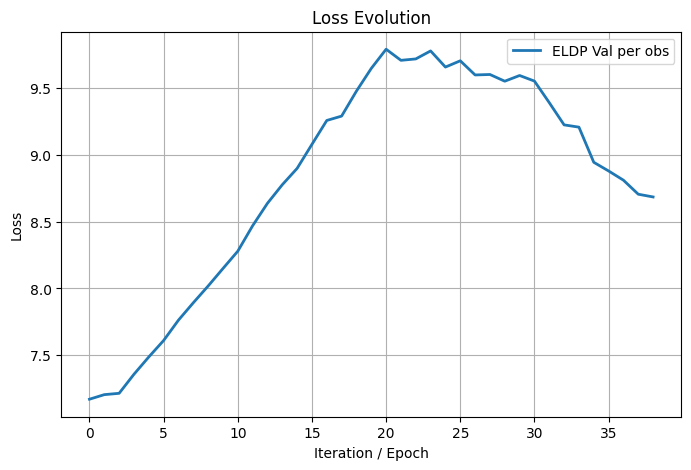

In [12]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [13]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [14]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [15]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.024
KLD GTM      Train Data:  0.0191
KLD Gaussian Train Data:  0.0188
KLD Copula   Train Data:  0.3436

KLD BGTM      Test  Data:  0.0374
KLD GTM      Test  Data:  0.0359
KLD Gaussian Test  Data:  0.0386
KLD Copula   Test  Data:  0.372


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [16]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

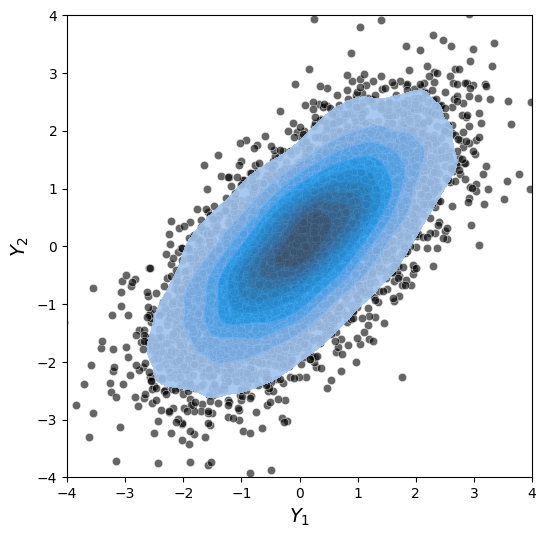

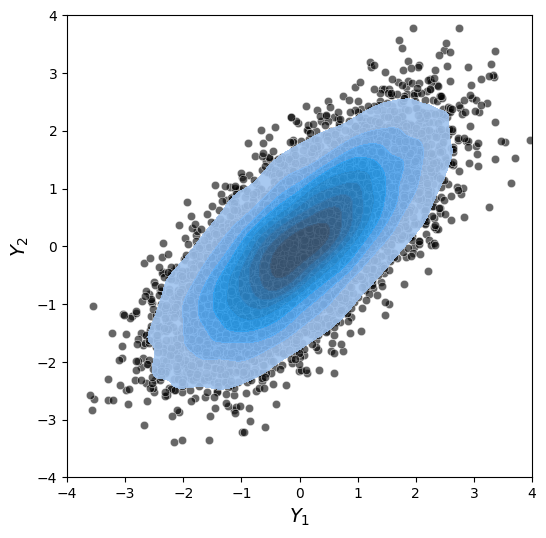

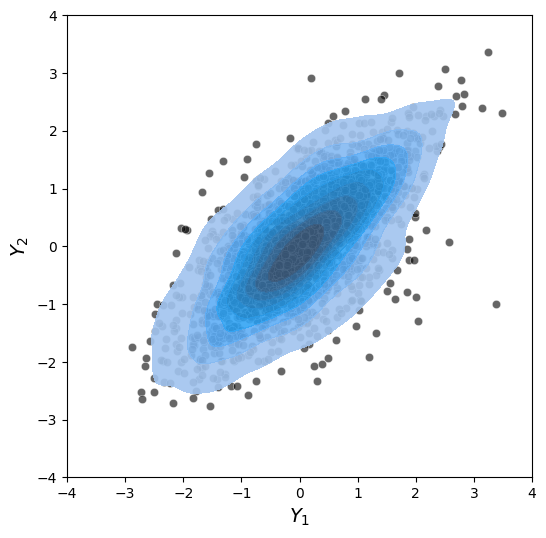

In [17]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


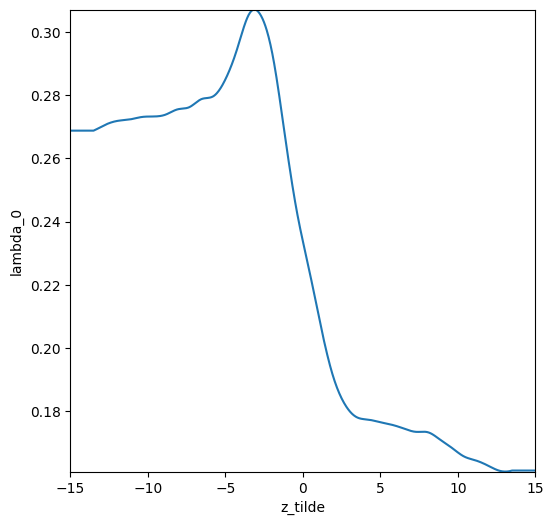

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


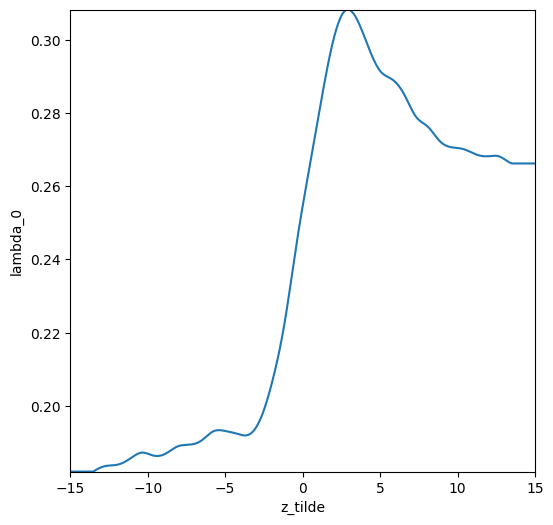

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


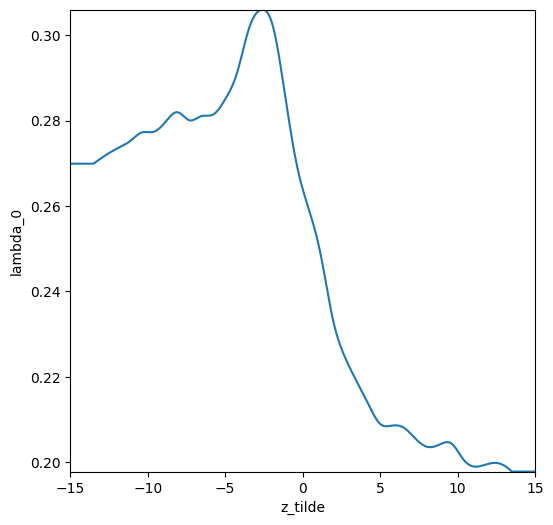

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)